# Library

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    pairwise_distances
)

from sklearn.metrics import make_scorer, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import plotly.express as px
import plotly.graph_objects as go
import shap

# Load Dataset

In [13]:
# Load dataset
df = pd.read_csv("D:/Study/Porto/Mall_Customers.csv")


# EDA

In [14]:
# 1.1 3D Interactive Visualization
fig = px.scatter_3d(df, 
                    x='Age', 
                    y='Annual Income (k$)', 
                    z='Spending Score (1-100)',
                    color='Gender',
                    symbol='Gender',
                    size_max=10,
                    opacity=0.7)
fig.update_layout(title='3D Customer Distribution')
fig.show()

c:\Users\rifal\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



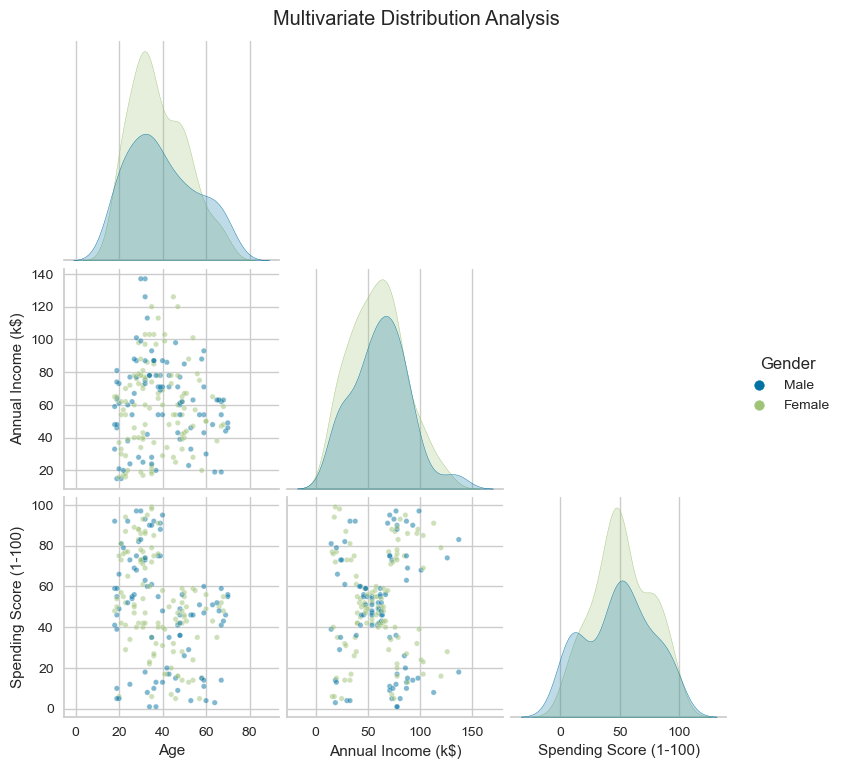

In [15]:
# 1.2 Pairplot dengan Density Estimation
g = sns.pairplot(df.drop('CustomerID', axis=1), 
                 hue='Gender', 
                 diag_kind='kde',
                 plot_kws={'alpha':0.5, 's':15},
                 corner=True)
g.fig.suptitle('Multivariate Distribution Analysis', y=1.02)
plt.show()

<Figure size 1200x800 with 0 Axes>

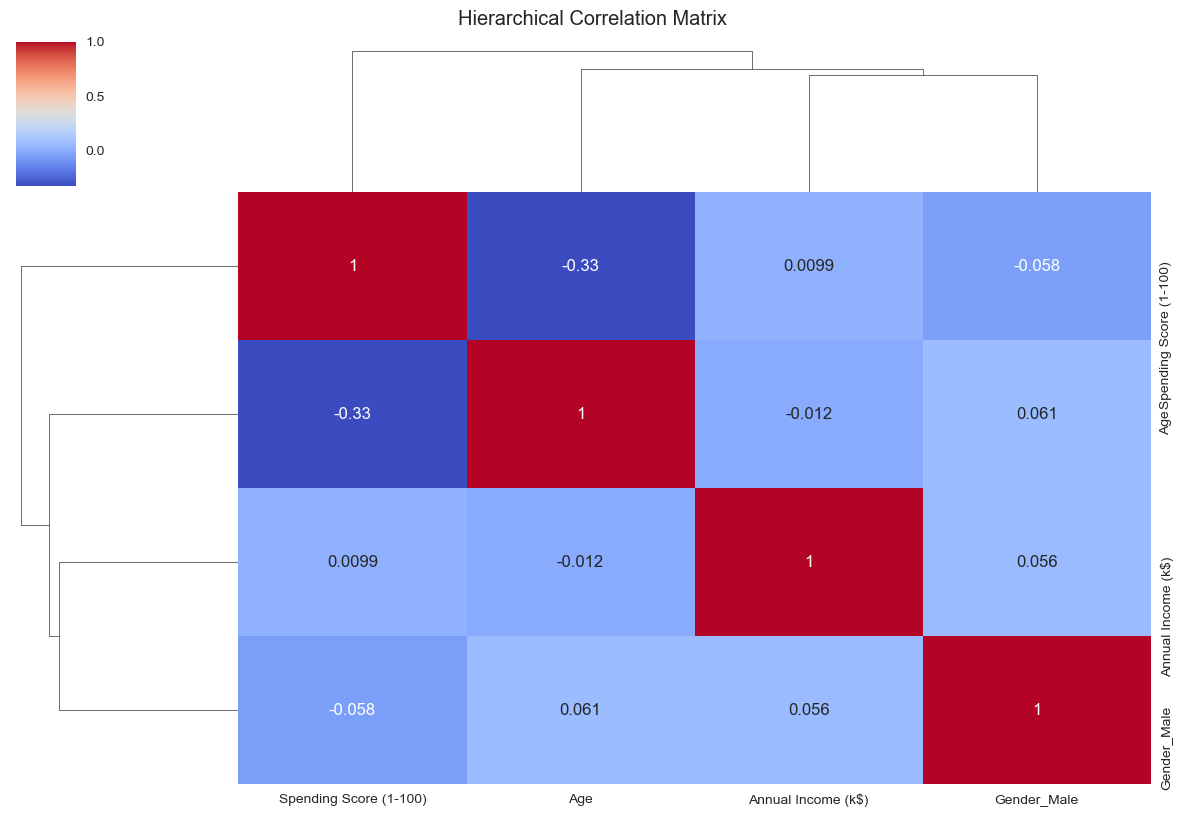

In [18]:
# 1.3 Correlation Matrix dengan Clustering

df = pd.get_dummies(df, drop_first=True)


plt.figure(figsize=(12,8))
g = sns.clustermap(df.drop('CustomerID', axis=1).corr(), 
                   annot=True, 
                   cmap='coolwarm',
                   row_cluster=True,
                   col_cluster=True,
                   figsize=(12, 8))  

g.fig.suptitle('Hierarchical Correlation Matrix', y=1.02)
plt.show()

# Preprocessing

In [19]:
# 2.1 Feature Engineering
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

In [20]:
# 2.2 Polynomial Features untuk menangkap non-linearitas
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

In [21]:
# 2.3 Advanced Scaling dengan RobustScaler
preprocessor = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, random_state=42)
)

X_processed = preprocessor.fit_transform(X_poly)

# Modelling

In [26]:
silhouette_scorer = make_scorer(silhouette_score)
davies_bouldin_scorer = make_scorer(davies_bouldin_score)

# Model clustering dan parameter
models = {
    'K-Means': {
        'model': KMeans(random_state=42),
        'params': {
            'n_clusters': range(2, 8),
            'init': ['k-means++', 'random']
        }
    },
    'DBSCAN': {
        'model': DBSCAN(),
        'params': {
            'eps': np.linspace(0.5, 2.0, 20),
            'min_samples': range(3, 10)
        }
    },
    'Gaussian Mixture': {
        'model': GaussianMixture(random_state=42),
        'params': {
            'n_components': range(2, 8),
            'covariance_type': ['full', 'tied', 'diag', 'spherical']
        }
    },
    'Hierarchical': {
        'model': AgglomerativeClustering(),
        'params': {
            'n_clusters': range(2, 8),
            'linkage': ['ward', 'complete', 'average', 'single']
        }
    }
}


In [27]:
# Optimasi parameter dengan Grid Search
results = {}
for name, config in models.items():
    gs = GridSearchCV(
        config['model'], 
        config['params'],
        scoring={
            'silhouette': silhouette_scorer,
            'davies_bouldin': davies_bouldin_scorer
        },
        refit='silhouette',
        cv=5,
        n_jobs=-1
    )

    gs.fit(X_processed)  # X_processed harus berupa array numerik

    best_model = gs.best_estimator_
    labels = best_model.fit_predict(X_processed) if name != 'Gaussian Mixture' else best_model.predict(X_processed)

    results[name] = {
        'model': best_model,
        'labels': labels,
        'metrics': {
            'silhouette': silhouette_score(X_processed, labels),
            'davies_bouldin': davies_bouldin_score(X_processed, labels),
            'calinski_harabasz': calinski_harabasz_score(X_processed, labels)
        },
        'params': gs.best_params_
    }

c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]

c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

# Visualization

### 4.1 3D Cluster Comparison

In [28]:
fig = px.scatter_3d(df, 
                    x='Age', 
                    y='Annual Income (k$)', 
                    z='Spending Score (1-100)',
                    color=results['Gaussian Mixture']['labels'].astype(str),
                    size_max=10,
                    opacity=0.7,
                    title='GMM Clustering (Best Model)')
fig.update_traces(marker=dict(size=5))
fig.show()

### 4.2 UMAP Projection dengan Cluster Boundaries

c:\Users\rifal\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



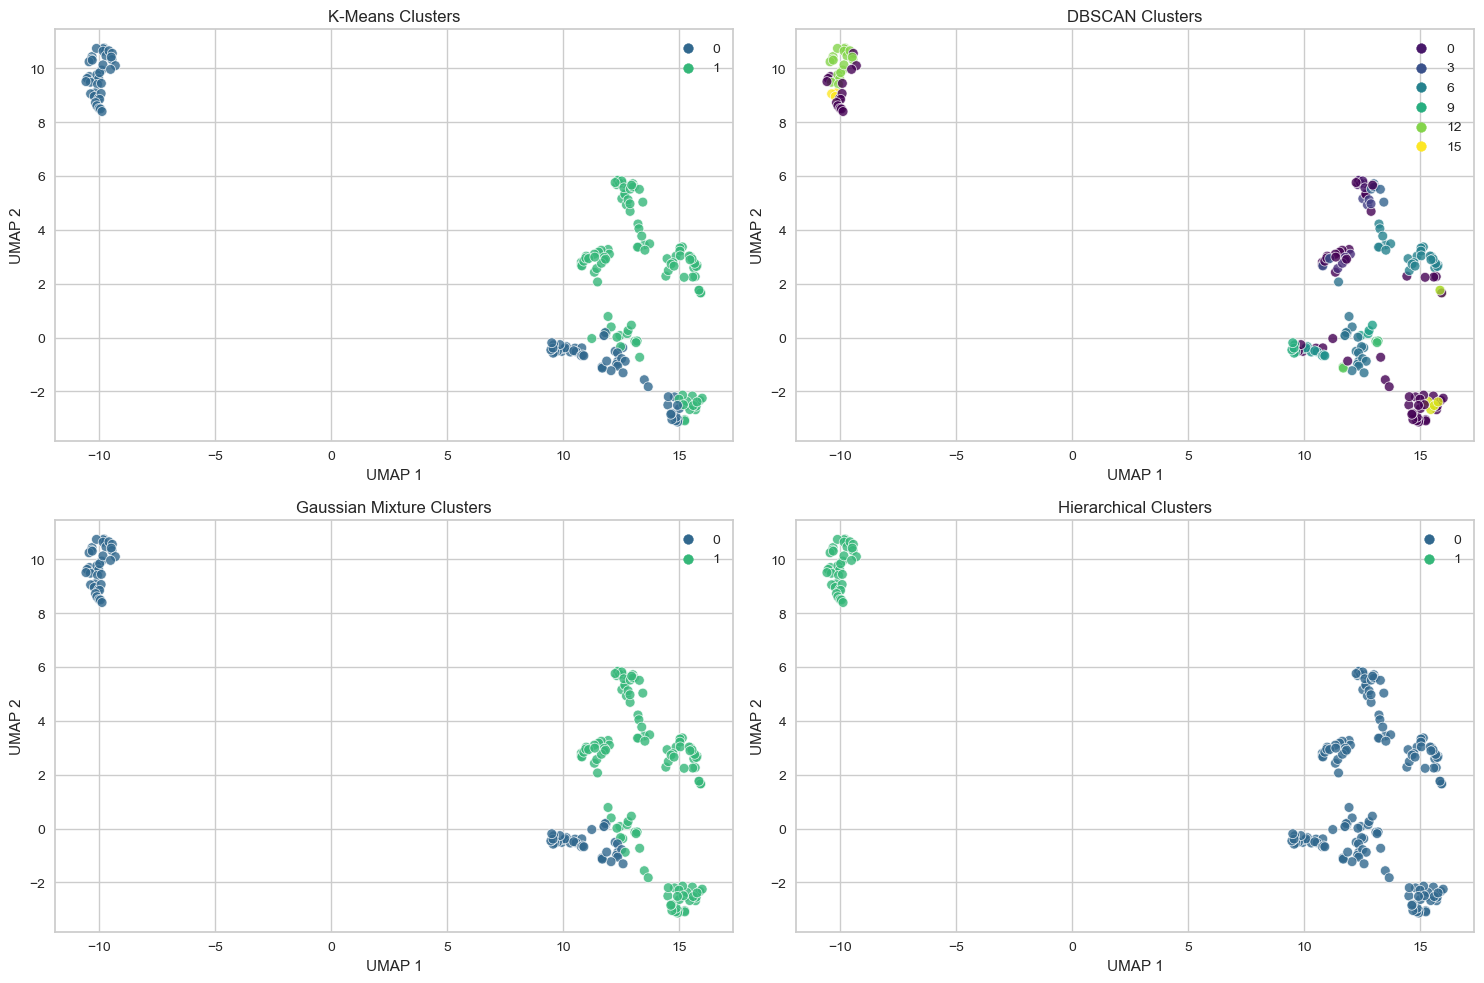

In [29]:
from umap import UMAP

# UMAP Embedding
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_processed)

# Plot Cluster Boundaries
plt.figure(figsize=(15,10))
for name in results:
    plt.subplot(2,2,list(results.keys()).index(name)+1)
    sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], 
                    hue=results[name]['labels'], 
                    palette='viridis',
                    s=50,
                    alpha=0.8)
    plt.title(f'{name} Clusters')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()

### 4.3 SHAP untuk Interpretasi Cluster

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\rifal\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning:

The figure layout has changed to tight

c:\Users\rifal\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:624: UserWarning:

The figure layout has changed to tight



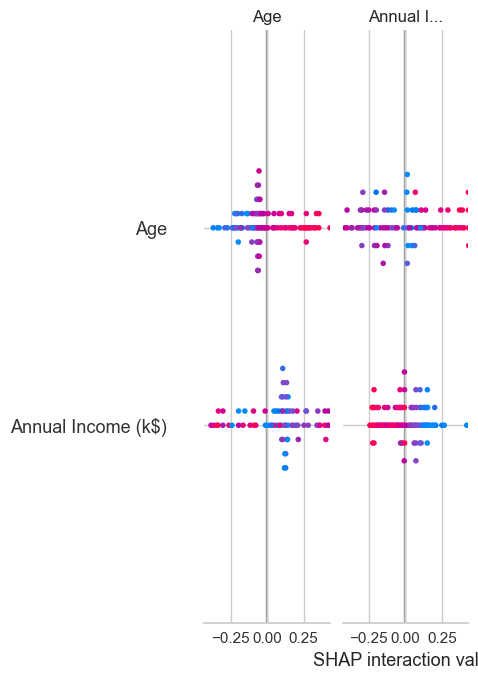

In [30]:
# Pilih model terbaik
best_model = results['Gaussian Mixture']['model']
explainer = shap.KernelExplainer(best_model.predict_proba, X_processed[:100])
shap_values = explainer.shap_values(X_processed[:100])

# Summary plot
shap.summary_plot(shap_values, 
                 features=X_processed[:100], 
                 feature_names=poly.get_feature_names_out(),
                 class_names=[f'Cluster {i}' for i in range(best_model.n_components)])

# Analisis Segmentasi

In [34]:
print(df.columns)

Index(['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Gender_Male'],
      dtype='object')


In [35]:
# 5.1 Profiling Cluster
df_clusters = df.copy()
for name in results:
    df_clusters[f'{name}_Cluster'] = results[name]['labels']

# Analisis demografi per cluster
cluster_profile = df_clusters.groupby('Gaussian Mixture_Cluster').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean',
    'Gender_Male': lambda x: round(x.mean() * 100, 2)  # Persentase Male
}).reset_index()


print("\nCluster Profiling:")
print(cluster_profile)


Cluster Profiling:
   Gaussian Mixture_Cluster        Age  Annual Income (k$)  \
0                         0  45.051282           70.487179   
1                         1  34.885246           54.213115   

   Spending Score (1-100)  Gender_Male  
0               66.320513        44.87  
1               39.893443        43.44  


In [36]:
# 5.2 Radar Chart untuk Perbandingan Cluster
fig = go.Figure()

for cluster in cluster_profile['Gaussian Mixture_Cluster']:
    fig.add_trace(go.Scatterpolar(
        r=cluster_profile.loc[cluster_profile['Gaussian Mixture_Cluster'] == cluster, 
                            ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values[0],
        theta=['Age', 'Annual Income', 'Spending Score'],
        fill='toself',
        name=f'Cluster {cluster}'
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
        visible=True
        )),
    title="Radar Chart: Cluster Characteristics"
)

fig.show()

# Validasi & Deployment

In [38]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Mengatasi memory leak pada Windows dengan MKL
os.environ["OMP_NUM_THREADS"] = "1"

stability_scores = {}
for name in results:
    original_labels = results[name]['labels']
    scores = []
    for _ in range(50):
        X_bootstrap = resample(X_processed, random_state=_)
        model = results[name]['model']
        
        # Pastikan model memiliki parameter n_init jika menggunakan KMeans
        if isinstance(model, KMeans):
            model = KMeans(n_clusters=model.n_clusters, random_state=42, n_init=10)
        
        labels = model.fit_predict(X_bootstrap)
        score = adjusted_rand_score(original_labels, labels)  # Tidak akan error lagi
        scores.append(score)
    
    stability_scores[name] = np.mean(scores)

print("\nCluster Stability Scores:")
print(pd.Series(stability_scores))


c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 


Cluster Stability Scores:
K-Means             0.000376
DBSCAN              0.001955
Gaussian Mixture   -0.002110
Hierarchical       -0.001118
dtype: float64


In [39]:
# 6.2 Deployment Pipeline
final_pipeline = make_pipeline(
    poly,
    preprocessor,
    results['Gaussian Mixture']['model']
)

import joblib
joblib.dump(final_pipeline, 'customer_clustering_pipeline.pkl')

['customer_clustering_pipeline.pkl']